In [1]:
#isolate surface bonds filter 
import sys
import numpy as np
import math
import pandas as pd
all_atoms = pd.read_csv('surface_atoms.csv')
all_atoms = pd.DataFrame(all_atoms, columns=['ID','molecule','type','charge', 'position','periodic image','selection'])
surf_atoms = all_atoms[all_atoms['selection']==1]
surf_ID = []
for i in surf_atoms['ID']:
    surf_ID.append(i)

display(len(surf_ID)/len(all_atoms))

0.6842795171633346

In [25]:
#Importing modules after converting into python3. Variables( their values are assigned after)
import sys
import numpy as np
import math
import pandas as pd


frames = 421

def read_header(f): #comments correspond to dump file headings
	f.readline() # ITEM: TIMESTEP
	timestep = int(f.readline())

	f.readline() # ITEM: NUMBER OF ATOMS
	num_atoms = int(f.readline())

	f.readline() # ITEM: BOX BOUNDS xx yy zz
	line = f.readline()
	line = line.split()
	xlo = float(line[0])
	xhi = float(line[1])
	line = f.readline()
	line = line.split()
	ylo = float(line[0])
	yhi = float(line[1])
	line = f.readline()
	line = line.split()
	zlo = float(line[0])
	zhi = float(line[1])

	return timestep, num_atoms, xlo, xhi, ylo, yhi, zlo, zhi

print(timestep, num_atoms, xlo, xhi, ylo, yhi, zlo, zhi)

[       1        2        4        8       16       32       64      128
      256      512     1024     2048     4096     8192    16384    32768
    65536   131072   262144   524288  1048576  1048577  1048578  1048580
  1048584  1048592  1048608  1048640  1048704  1048832  1049088  1049600
  1050624  1052672  1056768  1064960  1081344  1114112  1179648  1310720
  1572864  2097152  2097153  2097154  2097156  2097160  2097168  2097184
  2097216  2097280  2097408  2097664  2098176  2099200  2101248  2105344
  2113536  2129920  2162688  2228224  2359296  2621440  3145728  3145729
  3145730  3145732  3145736  3145744  3145760  3145792  3145856  3145984
  3146240  3146752  3147776  3149824  3153920  3162112  3178496  3211264
  3276800  3407872  3670016  4194304  4194305  4194306  4194308  4194312
  4194320  4194336  4194368  4194432  4194560  4194816  4195328  4196352
  4198400  4202496  4210688  4227072  4259840  4325376  4456448  4718592
  5242880  5242881  5242882  5242884  5242888  5242

In [16]:
#initialize system

fname = '/Users/alotmi.m/Desktop/analysis_OPLS/TRP/20ns/prod.lammpstrj'
f = open(fname, 'r')
file = 'bacf_bulk.csv'

# read in the initial header
frame = 0
init_timestep, num_atoms, xlo, xhi, ylo, yhi, zlo, zhi = read_header(f)

# it is not possible to preallocate arrays (or to know number of frames in advance)
num_frames = float('inf')
alloc = 1
inf_frames = True

timestep = np.zeros(alloc,int) # 1D array of timesteps
box_bounds = np.zeros([alloc,3,2],float) # 3D array to store boundaries of the box, indexed by frame, x/y/z, then lower/upper
print(timestep)
print(box_bounds)
print(frame)
timestep[frame] = init_timestep
box_bounds[frame][0][0] = xlo
box_bounds[frame][0][1] = xhi
box_bounds[frame][1][0] = ylo
box_bounds[frame][1][1] = yhi
box_bounds[frame][2][0] = zlo
box_bounds[frame][2][1] = zhi

# NOTE: using num_atoms+1 here so that the arrays are indexed by their LAMMPS atom id
r = np.zeros([alloc, num_atoms+1, 3],float) # 3D array of x, y, z coordinates, r[frame][id][coordinate]
ir = np.zeros([alloc, num_atoms+1, 3],int) # 3D array of x, y, z image flags, r[frame][id][coordinate]

id2mol = np.zeros(num_atoms+1,int) # array to map from atom id to molecule id, builds this from the first frame, if available
id2type = np.zeros(num_atoms+1,int) # array to map from atom id to type, builds this from the first frame, if available


[0]
[[[0. 0.]
  [0. 0.]
  [0. 0.]]]
0


In [17]:

# separately do the first ATOMS section so that we can initialize things, build the id2mol and id2type arrays, and so that the main loop starts with reading in the header
line = f.readline()
line = line.split()
id_index = line.index("id") - 2   #position of id-2
print (line)
if "mol" in line:
	mol_index = line.index("mol") - 2
else:
	mol_index = None
print(mol_index)
if "type" in line:
	type_index = line.index("type") - 2
else:
	type_index = None
print(type_index)
if "x" in line:
	scaled = False
	x_index = line.index("x") - 2
	y_index = line.index("y") - 2
	z_index = line.index("z") - 2
elif "xs" in line:
	scaled = True
	x_index = line.index("xs") - 2
	y_index = line.index("ys") - 2
	z_index = line.index("zs") - 2
print(x_index, " ",y_index)
if "ix" in line:
	ix_index = line.index("ix") - 2
	iy_index = line.index("iy") - 2
	iz_index = line.index("iz") - 2



['ITEM:', 'ATOMS', 'id', 'mol', 'type', 'q', 'xs', 'ys', 'zs', 'ix', 'iy', 'iz']
1
2
4   5


In [18]:

# loop over the atoms lines
for atom in range(num_atoms):
	line = f.readline()
	line = line.split()
	# get the atom id
	my_id = int(line[id_index])
	# x, y, z coordinates
	r[frame][my_id][0] = float(line[x_index])
	r[frame][my_id][1] = float(line[y_index])
	r[frame][my_id][2] = float(line[z_index])

	# unscale, if necessary
	if scaled:
		r[frame][my_id][0] = r[frame][my_id][0]*(box_bounds[frame][0][1]-box_bounds[frame][0][0]) + box_bounds[frame][0][0]
		r[frame][my_id][1] = r[frame][my_id][1]*(box_bounds[frame][1][1]-box_bounds[frame][1][0]) + box_bounds[frame][1][0]
		r[frame][my_id][2] = r[frame][my_id][2]*(box_bounds[frame][2][1]-box_bounds[frame][2][0]) + box_bounds[frame][2][0]

	# x, y, z image flags
	ir[frame][my_id][0] = int(line[ix_index])
	ir[frame][my_id][1] = int(line[iy_index])
	ir[frame][my_id][2] = int(line[iz_index])

	# if available, build the i2mol and id2type arrays
	if mol_index is not None:
		id2mol[my_id] = int(line[mol_index])
	if type_index is not None:
		id2type[my_id] = int(line[type_index])

In [19]:

# build the reverse of the id2mol array
# this is a 2D array with rows of (potentially) varying length, so nest a numpy array into a python list
if mol_index is not None:
	num_mols = id2mol.max()	
	mol2ids = [[]]
	for molid in range(1, num_mols+1):
		mol2ids.append(np.where(id2mol==molid)[0]) ## mol2ids :[[1,2,3,4...*nmonomers{atom id}],...*npoly {mol id}]
else:
	num_mols = None
	mol2ids = None

# loop over number of num_frames frames, if num_frames is infinite, will look over all the frames in the file
frame = 1
print ("reading input file...")
while frame < num_frames:
	#print frame
	# try to read in a new header
	try:
		my_timestep, my_num_atoms, my_xlo, my_xhi, my_ylo, my_yhi, my_zlo, my_zhi = read_header(f)
	except:
        #print >> sys.stderr, "WARNING: hit end of file when reading in", fname, "at frame", frame
        	break

	# if we don't know how many frames to read in, have to allocate more memeory for the arrays
	if inf_frames:
		timestep = np.append(timestep, 0)
		box_bounds = np.concatenate( ( box_bounds, np.zeros([1,3,2], float) ) )
		r = np.concatenate( ( r, np.zeros([1, num_atoms+1, 3], float) ) )
		ir = np.concatenate( ( ir, np.zeros([1, num_atoms+1, 3], float) ) )
		
	# update the timestep and box size arrays
	timestep[frame] = my_timestep
	box_bounds[frame][0][0] = my_xlo
	box_bounds[frame][0][1] = my_xhi
	box_bounds[frame][1][0] = my_ylo
	box_bounds[frame][1][1] = my_yhi
	box_bounds[frame][2][0] = my_zlo
	box_bounds[frame][2][1] = my_zhi

	f.readline() # ITEM: ATOMS
	# loop over the atoms lines
	for atom in range(num_atoms):
		line = f.readline()
		line = line.split()

		# get the atom id
		my_id = int(line[id_index])
	
		# x, y, z coordinates
		r[frame][my_id][0] = float(line[x_index])
		r[frame][my_id][1] = float(line[y_index])
		r[frame][my_id][2] = float(line[z_index])

		# unscale, if necessary
		if scaled:
			r[frame][my_id][0] = r[frame][my_id][0]*(box_bounds[frame][0][1]-box_bounds[frame][0][0]) + box_bounds[frame][0][0]
			r[frame][my_id][1] = r[frame][my_id][1]*(box_bounds[frame][1][1]-box_bounds[frame][1][0]) + box_bounds[frame][1][0]
			r[frame][my_id][2] = r[frame][my_id][2]*(box_bounds[frame][2][1]-box_bounds[frame][2][0]) + box_bounds[frame][2][0]

		# x, y, z image flags
		ir[frame][my_id][0] = int(line[ix_index])
		ir[frame][my_id][1] = int(line[iy_index])
		ir[frame][my_id][2] = int(line[iz_index])
	
	frame += 1




reading input file...


In [20]:
print ("reading input file done, now calculating bonds")

if len(mol2ids[0]) == 0:
	del mol2ids[0]
navg = 1  

##Make a list of bonds from .lmps file#
df = pd.read_csv('/Users/alotmi.m/Desktop/analysis_OPLS/TRP/20ns/3Mequil.lmps')
#lines between word bonds and angles in datafile.......................
line1 = df.index[df['LAMMPS data file via write_data'].str.contains("Bonds")][0]
line2 = df.index[df['LAMMPS data file via write_data'].str.contains("Angles")][0]
df=df.iloc[line1:line2]
df.drop(index=line1,inplace=True)
ndf=df.drop(df.columns[1:3],axis=1)   
bondlist=[]                #filtered
for i in ndf['LAMMPS data file via write_data']:
    test_list=i.split()
    test_list = [int(i) for i in test_list]
    #bondlist.append(test_list)       #for all 
  
    #filter bonds on the surface
    if test_list[2] not in surf_ID or test_list[3] not in surf_ID:
        if test_list not in bondlist:
            bondlist.append(test_list)
display(len(bondlist))

# Now calculate bonds at different times
bond = np.zeros([frames,(len(bondlist)+1),3],float)          

bacf_autocorr = np.zeros([navg,frames],float)
bacf_autocorr_final = np.zeros([frames],float)

# #Over all frames and all bonds. We can define a if condition based on the type..................... 
results = np.zeros([frames, len(bondlist)+1 ,3])
for t in range(frames):
    for i, bond in enumerate(bondlist):
#       get the coordinates of the two atoms and subtract them
        Bbond = r[t][bond[2]]-r[t][bond[3]]
        
#       Normalize the difference and store it in results
        results[t][i] = (Bbond/(np.sqrt(np.dot(Bbond,Bbond))))

        
print(results.shape)
print ("averaging for different starting times...")
print("naverage = ", navg)
for t in range(0,navg):
    t1 = 21*t
    for t2 in range(t1,int((frames/navg)+t1)):
        dt = t2 - t1
        for b in range(len(bondlist)):
            bacf_autocorr[t][dt] += np.dot(results[t1][b], results[t2][b])

for avg in range(0,navg):
    for dt in range(int(frames/navg)):
        bacf_autocorr_final[dt] += bacf_autocorr[avg][dt]/navg

# Write output to file
OUT = open(file, 'w')
OUT.write("timesteps,BACF\n")
for t in range(int(frames/navg)):
    OUT.write("%7i, %7f\n" % ((timestep[t]), ((bacf_autocorr_final[t])/len(bondlist)))) ###
OUT.close()


reading input file done, now calculating bonds


64747

(421, 64748, 3)
averaging for different starting times...
naverage =  1


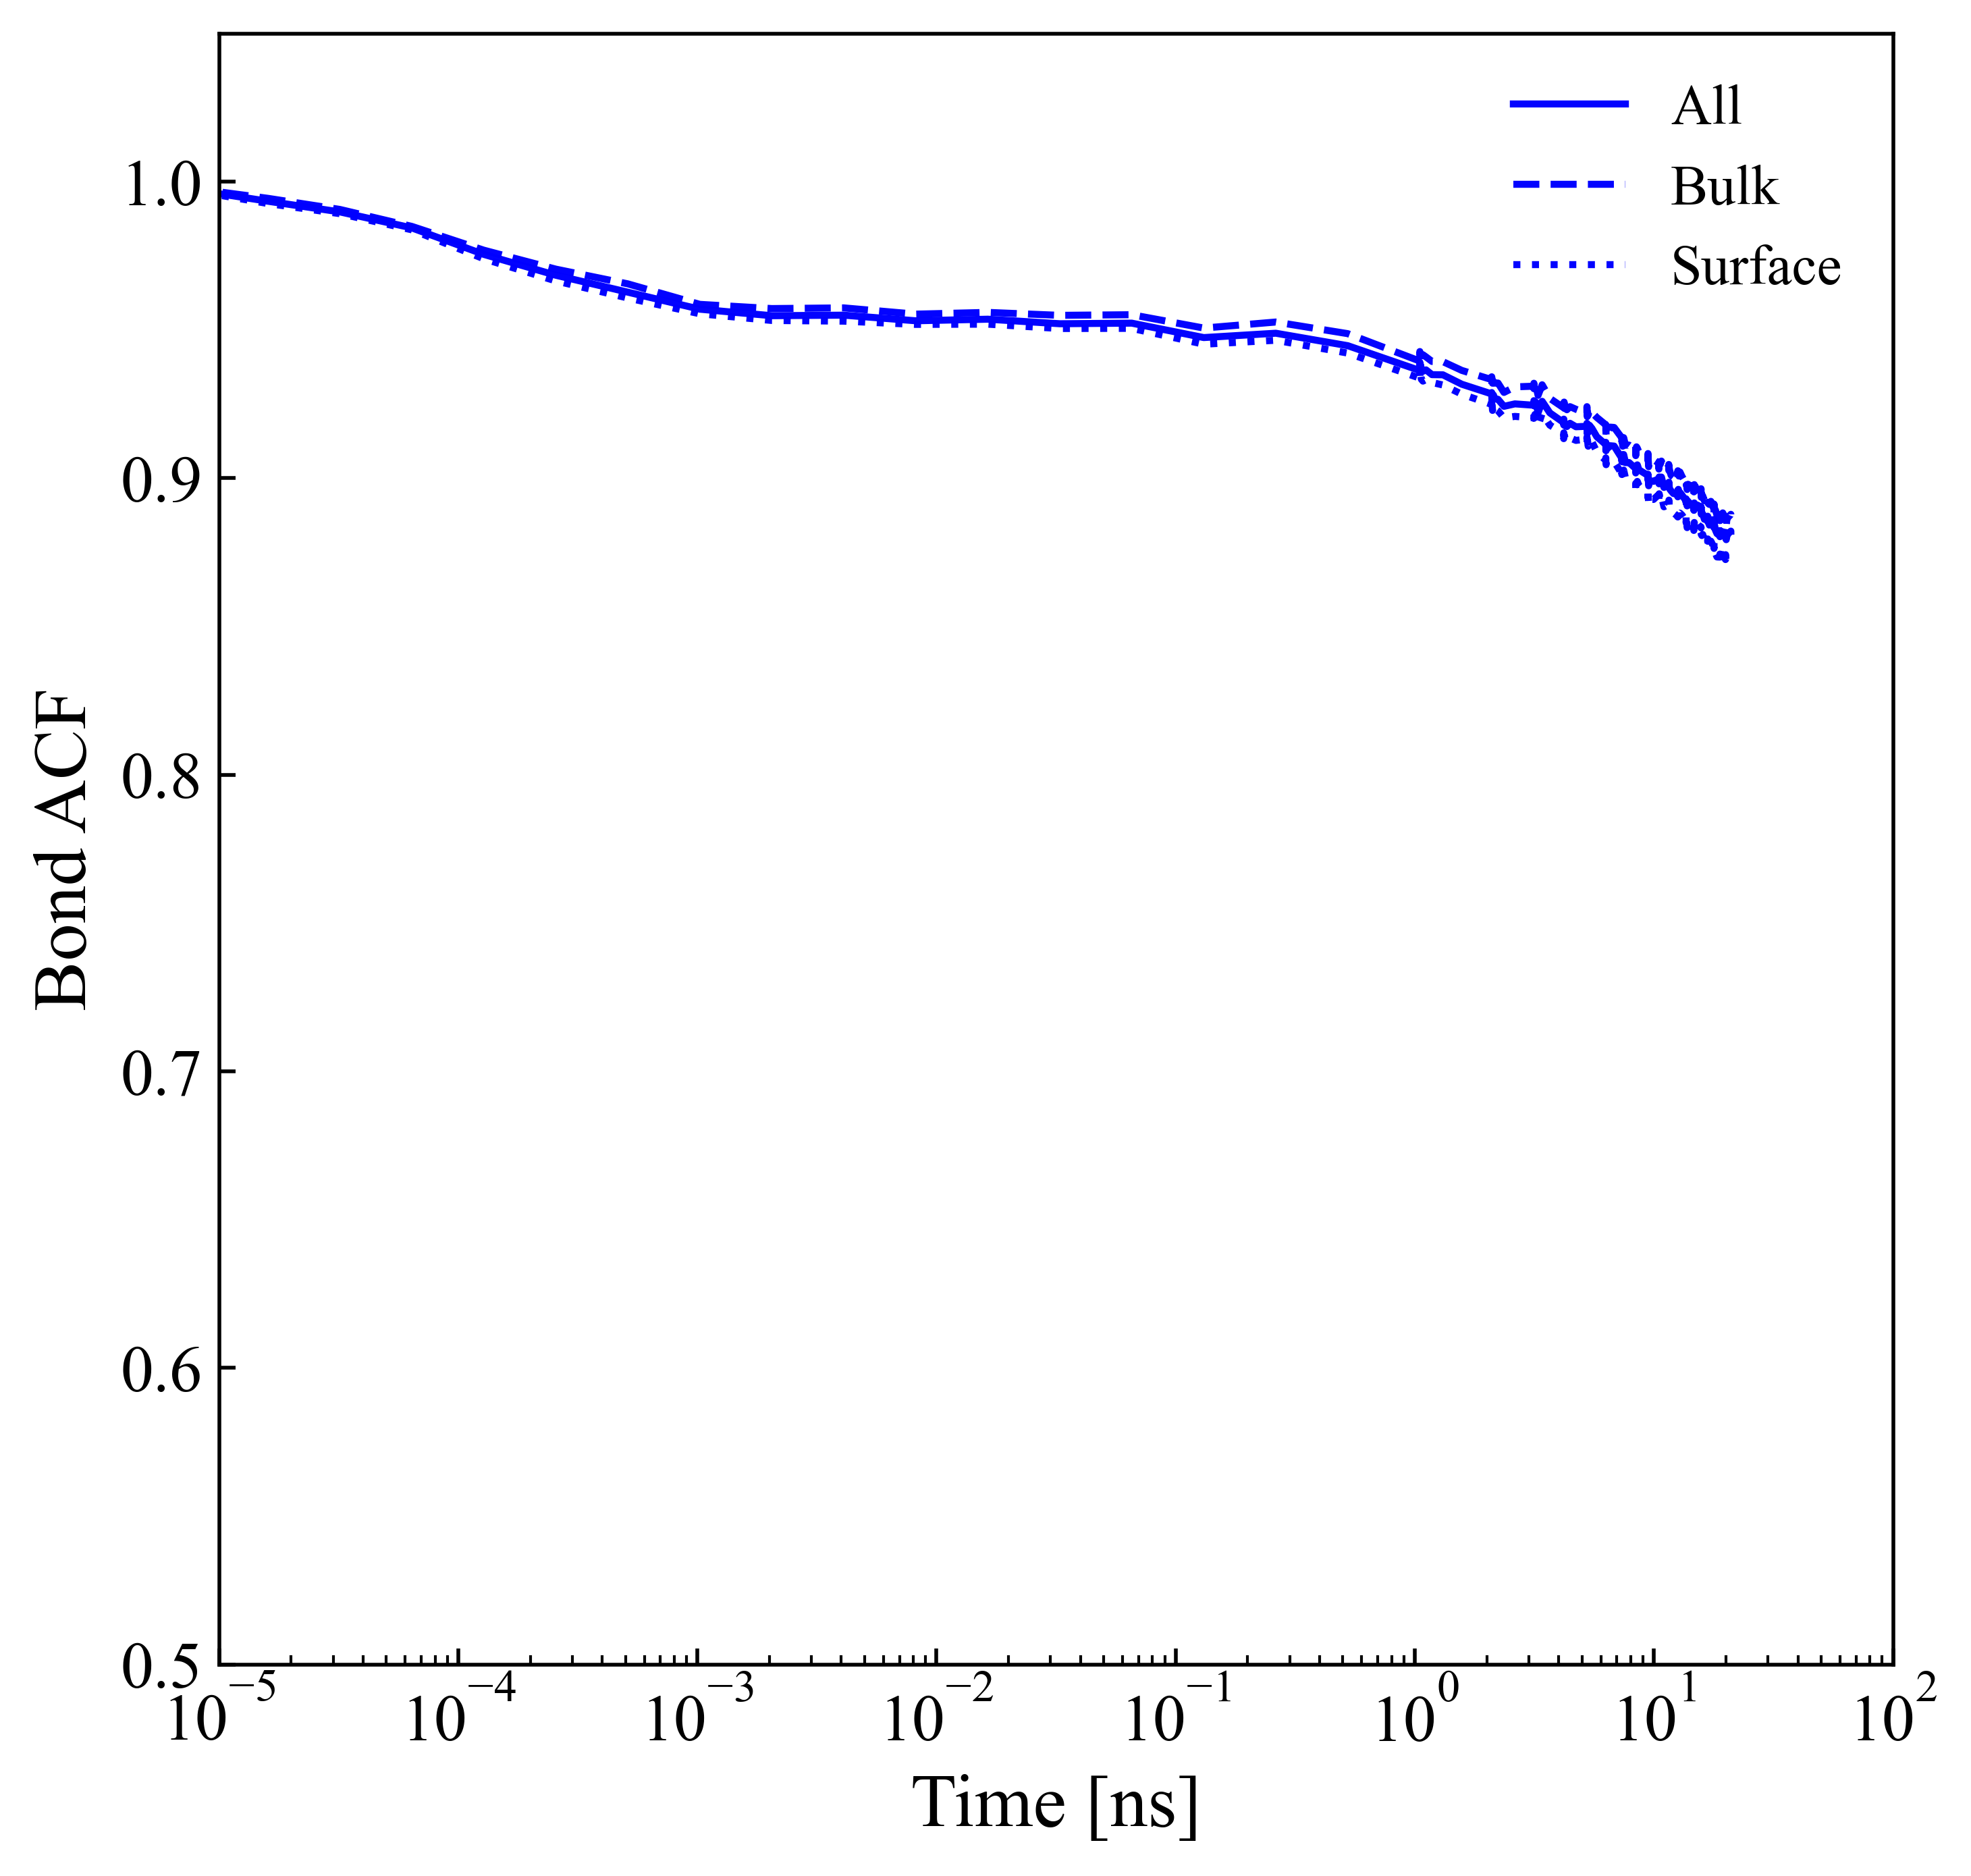

In [4]:
#plotting BACF
import matplotlib.pyplot as plt
import pylab

data0 = pd.read_csv('bacf_all.csv')
data = pd.DataFrame(data0, columns=['timesteps','BACF'])

data1 = pd.read_csv('bacf_bulk.csv')
data1 = pd.DataFrame(data1, columns=['timesteps','BACF'])

data2 = pd.read_csv('bacf_surf.csv')
data2 = pd.DataFrame(data2, columns=['timesteps','BACF'])

fig = plt.figure(figsize=(6.4,6.4), dpi=500)
ax = fig.add_subplot(1, 1, 1)
scatter1= ax.plot(data['timesteps']/1000000, data['BACF'],c="b", alpha=0.99 ,label="All")
scatter2= ax.plot(data1['timesteps']/1000000, data1['BACF'],c="b", linestyle='dashed', alpha=0.99,markersize=3, label="Bulk")
scatter2= ax.plot(data2['timesteps']/1000000, data2['BACF'],c="b", linestyle='dotted', alpha=0.99, markersize=3, label="Surface")


plt.rcParams.update({'font.family':'Times New Roman'})
# ax.set_yscale('log')
plt.ylim(0.5, 1.05)
ax.set_xscale('log')
plt.xlim(0.00001, 100)
plt.xlabel("Time [ns]",fontsize=16)
plt.ylabel("Bond ACF",fontsize=16) #change to nm, keep markers
plt.legend(loc='upper right', fontsize=12, frameon=0)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.tick_params(axis="x",which='minor', direction="in")
ax.tick_params(axis="y",which='minor', direction="in")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [6]:
# another way to filter by type is list of lists of lists
# results = []
# for t in range(frames):
#     result = []
#     for i in bondlist:
#         j = i[0] #bond index
#         if i[1]==3:
#             Bbond = r[t][i[2]]-r[t][i[3]]
#             result.append(Bbond/(np.sqrt(np.dot(Bbond,Bbond))))     
#     results.append(result)
    
# results = np.array(results)
# print(results.shape)
# print ("averaging for different starting times...")
# print("naverage = ", navg)
# for t in range(0,navg):
#     t1 = 21*t
#     for t2 in range(t1,int((frames/navg)+t1)):
#         dt = t2 - t1
#         for b in range(len(bondlist)):
#             bacf_autocorr[t][dt] += np.dot(results[t1][b], results[t2][b])

# for avg in range(0,navg):
#     for dt in range(int(frames/navg)):
#         bacf_autocorr_final[dt] += bacf_autocorr[avg][dt]/navg

# # Write output to file
# OUT = open(file, 'w')
# OUT.write("timesteps,BACF_type1\n")
# for t in range(int(frames/navg)):
#     OUT.write("%7i, %7f\n" % ((timestep[t]), ((bacf_autocorr_final[t])/len(bondlist)))) ###
# OUT.close()


# import matplotlib.pyplot as plt
# import pylab

# data0 = pd.read_csv('bacf.csv')
# data = pd.DataFrame(data0, columns=['timesteps','BACF_type1'])
# fig = plt.figure(figsize=(5,5), dpi=150)
# ax = fig.add_subplot(1, 1, 1)
# scatter1= ax.plot(data['timesteps'], data['BACF_type1'],c="g", alpha=0.5, marker='o',label="ACF_filtered")
# #ax.set_yscale('log')
# #plt.ylim(0.0, 1.1)
# ax.set_xscale('log')
# #plt.xlim(0.02, 6505025)

# plt.xlabel("Timestep (ps)",fontsize=16)
# plt.ylabel("ACF",fontsize=16)
# plt.legend(loc='upper right', fontsize=10)
# plt.show()